## Simulate Adiabatic Process with Qiskit

This article uses qiskit to simulate Adiabatic Process to find an optimizal solution of a Max-Cut problem.

### Adiabatic Theorem

Adiabatic Theorem says that if a system is in a ground state (or highest energy state) and the Hamiltonian changes slowly to a new one, the system will stay on ground state (or highest energy state) of the new Hamiltonian.

Given,
$$
\begin{align*}
X |+\rangle &= |+\rangle  \\
X |-\rangle &= -|-\rangle
\end{align*}
$$

For a Mixer Hamiltonian $H_M = \prod_i X_i$,

$|+\dots+\rangle$ is the corresponding highest energy state.

Define a Cost Hamiltonian $H_C$.  

and time vary Hamiltonian where $t\in[0, T]$

$$
\hat{H}(t) = (1 - \frac{t}{T})H_M + \frac{t}{T}H_C              \tag{1}
$$

Note: use $\hat{H}$ for hamiltonian to distinguish from Hadamard gate $H$.

According to Adiabatic Theorem, if applying $\hat{H}(t)$ to $|+\dots+\rangle$ with a big enough $T$, the final state is the highest energy state of $H_C$.

Taking T as a big enough integer, the highest energy state of $H_C$ can be approximated as

$$
\hat{H}(T) \hat{H}(T-1) \dots \hat{H}(1) \hat{H}(0) |+ \dots + \rangle      \tag{2}
$$


Schrodinger equation,

$$
\begin{align*}
\hat{H}|\psi(t)\rangle &= i \hbar \frac{\partial}{\partial t} |\psi(t)\rangle \\
|\psi(t) &= e^{-i \hat{H} t / \hbar} | \psi(0) \rangle                  \tag{3}
\end{align*}
$$

Apply equation (3) to (2), highest energy state $|\psi \rangle$ of $H_C$ becomes

$$
| \psi \rangle = e^{-i \hat{H}(T) / \hbar} e^{-i \hat{H}(T-1) / \hbar} \dots e^{-i \hat{H}(1) / \hbar} e^{-i \hat{H}(0) / \hbar} | + \dots + \rangle        \tag{4}
$$

In [1]:
# setup

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
import qiskit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

### Max-Cut example

5 nodes with node 0 connecting to every other nodes

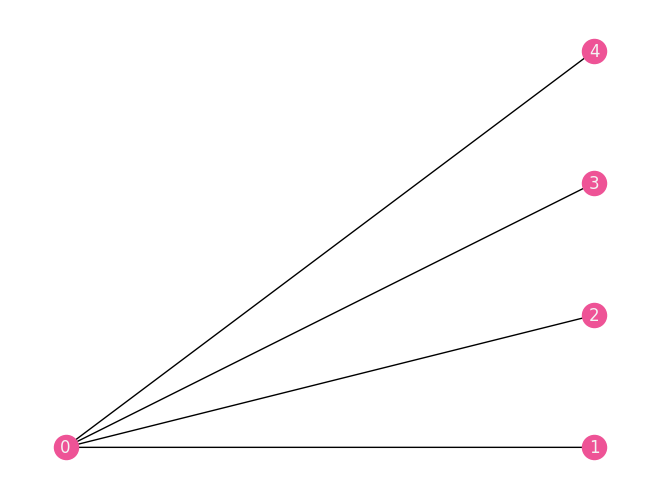

In [2]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

The goal is the separate the nodes into 2 sets such that the number of edges from one set to another is maximum.

The solution is represented as 5 qubits and the state 0 or 1 label the node in set 0 or set 1.  For example, $|00110 \rangle$ means nodes {0, 4, 5} in set 0 and nodes {1, 2} in set 1.

Define Cost Hamiltonian $H_C$,

$$
H_C = - IIIZZ - IIZIZ - IZIIZ - ZIIIZ           \tag{5}
$$

If nodes {0, 2, 3, 4} in set 0 and node {1} in set 1 i.e. $|00010 \rangle$,

$\langle 00010| (-IIIZZ) |00010 \rangle = 1$ which positively contribute to $H_C$ because edge01 (edge01 from node 0 to node 1) is in this cut configuration.

$\langle 00010| (-IIZIZ) |00010 \rangle = -1$ which negatively contribute to $H_C$ because edge02 (edge from node 0 to node 2) is not in this cut configuration.

A quantum state maximized $H_C$ is the solution of this Max-Cut problem.

Define Mixer Hamiltonian $H_M$,

$$
H_M = XXXXX         \tag{6}
$$

The Max-Cut solution quantum state can be found by substituting equations (5) and (6) to (1) and (2)

$$
\begin{align*}
| \psi \rangle &= e^{-i \hat{H}(T) / \hbar} e^{-i \hat{H}(T-1) / \hbar} \dots e^{-i \hat{H}(1) / \hbar} e^{-i \hat{H}(0) / \hbar} | +++++ \rangle   \\
&= e^{-i H_C / \hbar}
e^{-i (\frac{1}{T}XXXXX + \frac{T-1}{T}H_C) / \hbar}
\dots
e^{-i (\frac{T-1}{T}XXXXX + \frac{1}{T}H_C) / \hbar}
e^{-i XXXXX / \hbar}
|+++++>                                             \\
&= e^{-i H_C / \hbar}
e^{-i (\frac{1}{T}XXXXX + \frac{T-1}{T}H_C) / \hbar}
\dots
e^{-i (\frac{T-1}{T}XXXXX + \frac{1}{T}H_C) / \hbar}
|+++++>                                             \tag{7}
\end{align*}  
$$

### Trotter product formula

For $A$ and $B$ do not commute with large $N$,

$$
e^{A+B} \approx (e^{A/N} e^{B/N})^N             \tag{8}
$$


Apply equation (8) to (7) with large $T$ and $N$,

$$
| \psi \rangle = 
e^{-i H_C / \hbar}
(e^{-i (\frac{1}{TN}XXXXX)} e^{-i (\frac{T-1}{TN}H_C) / \hbar})^N
\dots
(e^{-i (\frac{T-1}{T}XXXXX)} e^{-i (\frac{1}{T}H_C) / \hbar})^N
|+++++>                                                         \tag{9}
$$

### Exponential of Pauli Matrices

Definition of exponential,

$$
e^M = \sum_{k=0}^{\inf} \frac{1}{k!} M^k
$$

and Pauli matrics,

$$
X = 
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix} 
, Y = 
\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}
, Z = 
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

With some calculations,

$$
\begin{align*}

e^{-i\theta X} &= R_X(2 \theta) =
\begin{pmatrix}
\cos(\theta)    & -i \sin(\theta)    \\
-i \sin(\theta) & \cos(\theta)
\end{pmatrix}                           \\
                                        \\
e^{-i\theta Y} &= R_Y(2 \theta) =
\begin{pmatrix}
\cos(\theta)    & \sin(\theta)    \\
\sin(\theta)    & \cos(\theta)
\end{pmatrix}                           \\
                                        \\
e^{-i\theta Z} &= R_Z(2 \theta) =
\begin{pmatrix}
e^{-i \theta}  & 0                 \\
0               & e^{i \theta}
\end{pmatrix}

\end{align*}
$$

Additionally, $e^{-i \theta Z \otimes Z} = R_{ZZ}(2 \theta)$,

$$
\begin{align*}

e^{-i \theta Z \otimes Z} &= 
e^{-i \theta 
\begin{pmatrix}
1   & 0     \\
0   & -1
\end{pmatrix}
\otimes
\begin{pmatrix}
1   & 0     \\
0   & -1
\end{pmatrix}
}                               \\

&= e^{-i \theta
\begin{pmatrix}
1   & 0     & 0     & 0     \\
0   & -1    & 0     & 0     \\
0   & 0     & -1    & 0     \\
0   & 0     & 0     & 1
\end{pmatrix}
}                               \\

&= e^{
\begin{pmatrix}
-i \theta   & 0     & 0     & 0     \\
0   & i \theta    & 0     & 0     \\
0   & 0     & i \theta    & 0     \\
0   & 0     & 0     & -i \theta
\end{pmatrix}
}                               \\

&= R_{ZZ}(2 \theta)

\end{align*}
$$

### Create a circuit

Create a quantum circuit to implement equation (9) to calculate $|\psi \rangle$.

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend = AerSimulator()
backend.name
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


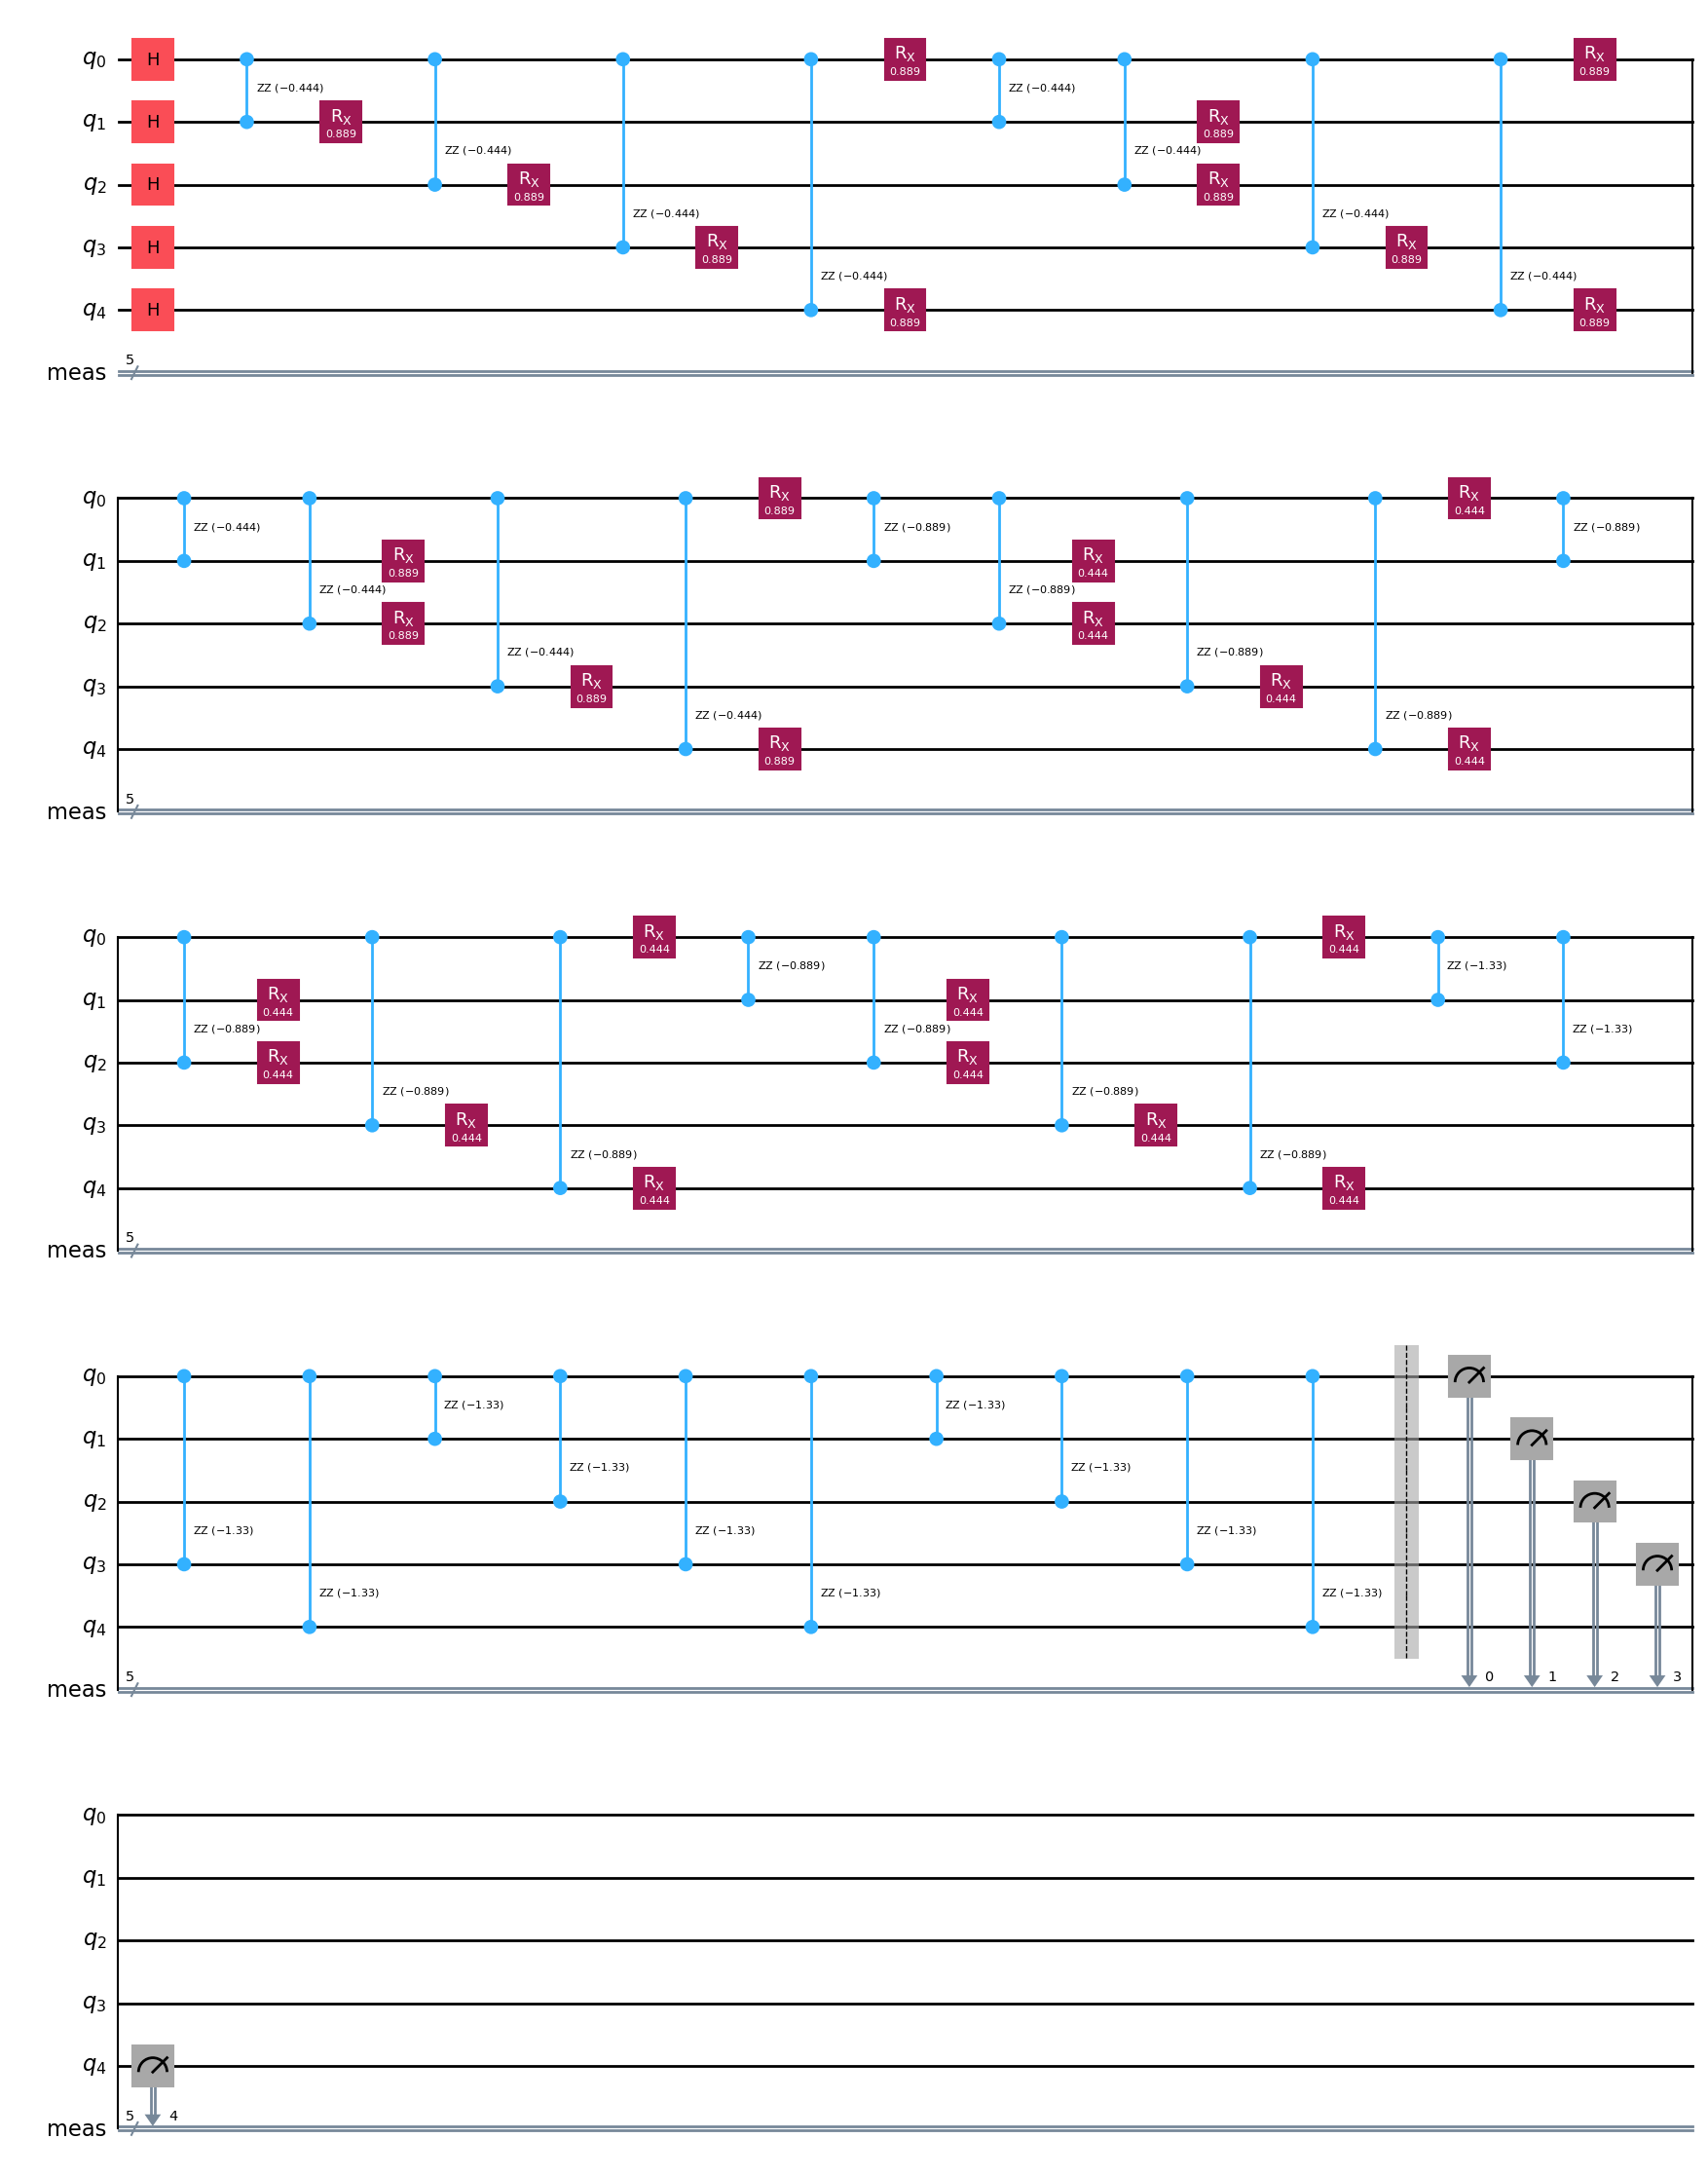

In [4]:
# Try 
T=3
N=3

# Problem to Hamiltonian operator
H_C = SparsePauliOp.from_list([("IIIZZ", -1), ("IIZIZ", -1), ("IZIIZ", -1), ("ZIIIZ", -1)])
# QAOA ansatz circuit repeating e^{H_C} and e^{H_M} "reps" times with gamma and beta parameters
ansatz = QAOAAnsatz(H_C, reps=T*N)

params = []

# parameters for H_M part of ansatz
for i in range(1, T+1):
    for j in range(N):
        params.append(2 * (1 - i * 1.0 / N) / T)  # beta R_X(2 \theta) 

# parameters for H_C part of ansatz
for i in range(1, T+1):
    for j in range(N):
        params.append(2 * (i * 1.0 / N) / T)      # gamma R_Z(2 \theta)



qc = ansatz.assign_parameters(params)
qc.measure_all()
qc_isa = pm.run(qc)

qc_isa.decompose(reps=0).draw(output='mpl')

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


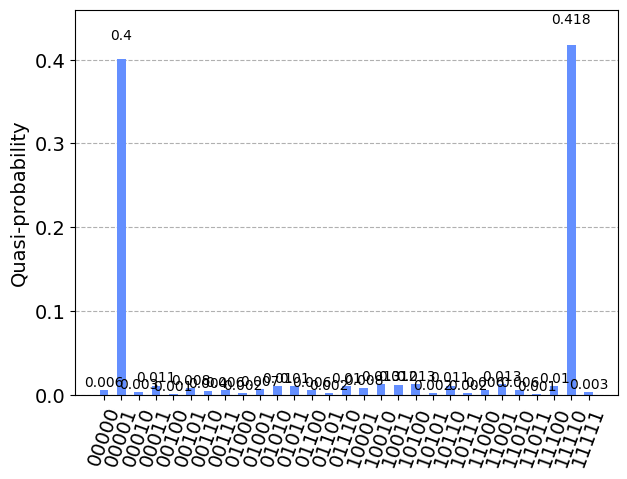

In [5]:
session = Session(backend=backend)
sampler = Sampler(session=session)
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
session.close()
plot_distribution(samp_dist)


### Max-Cut solution according to Adiabatic Process simulation

$|00001 \rangle$  and $|11110 \rangle$ show high probabilities.  They represent the sets {0} and {1, 2, 3, 4} are the Max-Cut solution.

### References:

1. Lecture 5.2 - Introduction to the Quantum Approximate Optimization Algorithm and Applications, https://www.youtube.com/watch?v=YpLzSQPrgSc
2. Tutorial - Quantum approximate optimization algorithm, https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm
3. Trotter product formula https://encyclopediaofmath.org/wiki/Trotter_product_formula
4. $R_{ZZ}$, https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZZGate

In [6]:
qiskit.__version__

'1.0.2'